In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score, roc_curve, average_precision_score, f1_score
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier
import warnings
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import display
from imblearn.over_sampling import RandomOverSampler

In [3]:
# import the data
X_train = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/CS334/X_train_scaled.csv")
X_test = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/CS334/X_test_scaled.csv")
y_train = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/CS334/y_train.csv")
y_test = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/CS334/y_test.csv")

In [4]:
# encode the target values following their natural order
order_mapping = {'neutral or dissatisfied': 0,'satisfied': 1}
y_train = y_train['satisfaction'].map(order_mapping)
y_test = y_test['satisfaction'].map(order_mapping)

In [9]:
# split the trainining data into subgroups
def split_data(trainX,trainy,testX,testy,group_criteria):
  """
  group criteria: a list of columns names to indicate the type of travel and the class according to which the group is sampled (where the value in the col should be true)
  [travel_purpose,seat_class]
  """
  purpose = group_criteria[0]
  seat_class = group_criteria[1]
  sub_trainX = trainX[(trainX[purpose] == 1) & (trainX[seat_class] == 1)]
  sub_testX = testX[(testX[purpose] == 1) & (testX[seat_class] == 1)]
  sub_trainy = trainy.iloc[sub_trainX.index]
  sub_testy = testy.iloc[sub_testX.index]
  print(f"{purpose},{seat_class}: consisted of {sub_trainX.shape[0]/trainX.shape[0]*100:.2f}% of the original train set; consisted of {sub_testX.shape[0]/testX.shape[0]*100:.2f}% of the original test set")
  return sub_trainX, sub_trainy, sub_testX, sub_testy

X_train_b_b,y_train_b_b,X_test_b_b,y_test_b_b = split_data(X_train,y_train,X_test,y_test,['Type of Travel_Business travel','Class_Business'])
X_train_b_e,y_train_b_e,X_test_b_e,y_test_b_e = split_data(X_train,y_train,X_test,y_test,['Type of Travel_Business travel','Class_Eco'])
X_train_b_ep,y_train_b_ep,X_test_b_ep,y_test_b_ep = split_data(X_train,y_train,X_test,y_test,['Type of Travel_Business travel','Class_Eco Plus'])

X_train_p_b,y_train_p_b,X_test_p_b,y_test_p_b = split_data(X_train,y_train,X_test,y_test,['Type of Travel_Personal Travel','Class_Business'])
X_train_p_e,y_train_p_e,X_test_p_e,y_test_p_e = split_data(X_train,y_train,X_test,y_test,['Type of Travel_Personal Travel','Class_Eco'])
X_train_p_ep,y_train_p_ep,X_test_p_ep,y_test_p_ep = split_data(X_train,y_train,X_test,y_test,['Type of Travel_Personal Travel','Class_Eco Plus'])



Type of Travel_Business travel,Class_Business: consisted of 45.74% of the original train set; consisted of 46.12% of the original test set
Type of Travel_Business travel,Class_Eco: consisted of 19.50% of the original train set; consisted of 19.42% of the original test set
Type of Travel_Business travel,Class_Eco Plus: consisted of 3.74% of the original train set; consisted of 3.90% of the original test set
Type of Travel_Personal Travel,Class_Business: consisted of 2.07% of the original train set; consisted of 1.99% of the original test set
Type of Travel_Personal Travel,Class_Eco: consisted of 25.48% of the original train set; consisted of 25.08% of the original test set
Type of Travel_Personal Travel,Class_Eco Plus: consisted of 3.46% of the original train set; consisted of 3.48% of the original test set


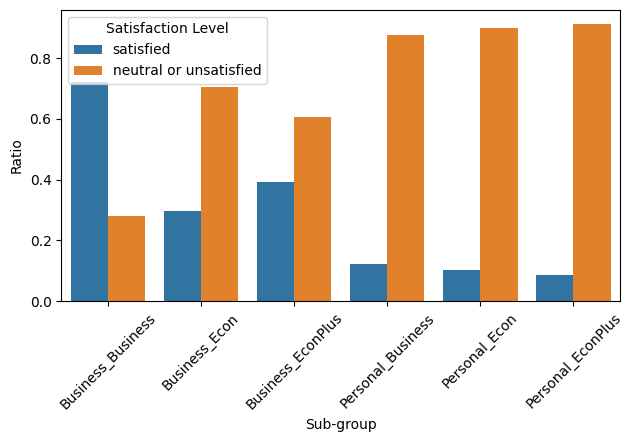

In [10]:
# check for data imbalance for each subgroup
subgroup_names = ['Business_Business','Business_Econ','Business_EconPlus','Personal_Business','Personal_Econ','Personal_EconPlus']
subgroup_list = [y_train_b_b,y_train_b_e,y_train_b_ep,y_train_p_b,y_train_p_e,y_train_p_ep]
posi_frac = [len(dt[dt==1])/dt.shape[0] for dt in subgroup_list]
neg_frac = [len(dt[dt==0])/dt.shape[0] for dt in subgroup_list]
result_list = [posi_frac,neg_frac]
df_imbalance = pd.DataFrame(result_list,index=['satisfied','neutral or unsatisfied'],columns=subgroup_names)
df_melted = df_imbalance.reset_index().melt(id_vars='index', var_name='Category', value_name='Value')

sns.barplot(x='Category', y='Value', hue='index', data=df_melted)
plt.xticks(rotation=90)
plt.xlabel('Sub-group')
plt.ylabel('Ratio')
plt.tight_layout()
plt.xticks(rotation=45)
leg = plt.legend()
leg.set_title('Satisfaction Level')
plt.savefig('subgroup_imbalance.png',format='png',dpi=800,bbox_inches='tight')
plt.show()


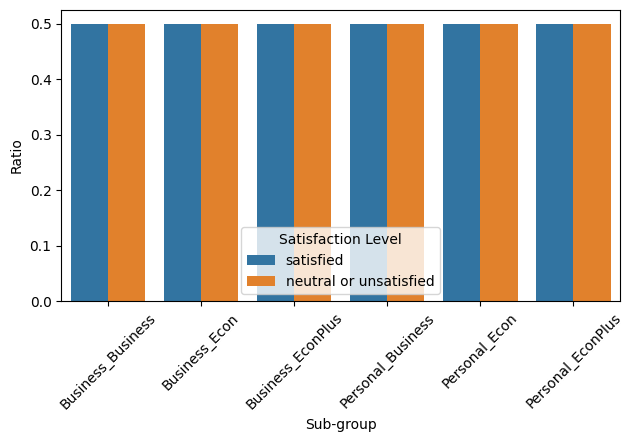

In [11]:
# adjust for imbalance
def oversample_minority(X,y):
  ros = RandomOverSampler(random_state=1227)
  X_adjusted, y_adjusted = ros.fit_resample(X, y)
  return X_adjusted, y_adjusted

X_train_b_b,y_train_b_b = oversample_minority(X_train_b_b,y_train_b_b)
X_train_b_e,y_train_b_e = oversample_minority(X_train_b_e,y_train_b_e)
X_train_b_ep,y_train_b_ep = oversample_minority(X_train_b_ep,y_train_b_ep)

X_train_p_b,y_train_p_b = oversample_minority(X_train_p_b,y_train_p_b)
X_train_p_e,y_train_p_e = oversample_minority(X_train_p_e,y_train_p_e)
X_train_p_ep,y_train_p_ep = oversample_minority(X_train_p_ep,y_train_p_ep)

# recheck for data imbalance
subgroup_names = ['Business_Business','Business_Econ','Business_EconPlus','Personal_Business','Personal_Econ','Personal_EconPlus']
subgroup_list = [y_train_b_b,y_train_b_e,y_train_b_ep,y_train_p_b,y_train_p_e,y_train_p_ep]
posi_frac = [len(dt[dt==1])/dt.shape[0] for dt in subgroup_list]
neg_frac = [len(dt[dt==0])/dt.shape[0] for dt in subgroup_list]
result_list = [posi_frac,neg_frac]
df_imbalance = pd.DataFrame(result_list,index=['satisfied','neutral or unsatisfied'],columns=subgroup_names)
df_melted = df_imbalance.reset_index().melt(id_vars='index', var_name='Category', value_name='Value')

sns.barplot(x='Category', y='Value', hue='index', data=df_melted)
plt.xticks(rotation=90)
plt.xlabel('Sub-group')
plt.ylabel('Ratio')
plt.tight_layout()
plt.xticks(rotation=45)
leg = plt.legend()
leg.set_title('Satisfaction Level')
plt.show()

In [12]:
# function for hyperparameter tuning using gridsearch
def eval_gridsearch(clf, pgrid, xTrain, yTrain, xTest, yTest):
  model = BaggingClassifier(base_estimator=clf, n_estimators=20, random_state=1227)

  grid_search = GridSearchCV(model, pgrid, cv=5)
  grid_search.fit(xTrain, yTrain)
  best_model = grid_search.best_estimator_

  y_pred_proba = best_model.predict_proba(xTest)[:, 1]
  auc = roc_auc_score(yTest, y_pred_proba)
  auprc = average_precision_score(yTest, y_pred_proba)
  y_pred = best_model.predict(xTest)
  f1 = f1_score(yTest, y_pred)

  fpr, tpr, _ = roc_curve(yTest, y_pred_proba)
  roc = {'fpr': fpr, 'tpr': tpr}
  bestParams = grid_search.best_params_
  resultDict = {'AUC': auc, 'AUPRC': auprc, 'F1': f1}
  return best_model, resultDict, roc, bestParams

In [13]:
# find the best decision tree for each subgroup\
warnings.filterwarnings('ignore')
#DT_grid = {'max_depth': [10, 20, 30],'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 5, 10]}
DT_bagging_grid = {'base_estimator__max_depth': [10, 20, 30], 'base_estimator__min_samples_split': [2, 5, 10], 'base_estimator__min_samples_leaf': [1, 5, 10]}

dtclf = DecisionTreeClassifier()
print("training model 1")
model_b_b,result_b_b,roc_b_b,para_b_b = eval_gridsearch(dtclf,DT_bagging_grid,X_train_b_b,y_train_b_b,X_test_b_b,y_test_b_b)
print("training model 2")
model_b_e,result_b_e,roc_b_e,para_b_e = eval_gridsearch(dtclf,DT_bagging_grid,X_train_b_e,y_train_b_e,X_test_b_e,y_test_b_e)
print("training model 3")
model_b_ep,result_b_ep,roc_b_ep,para_b_ep = eval_gridsearch(dtclf,DT_bagging_grid,X_train_b_ep,y_train_b_ep,X_test_b_ep,y_test_b_ep)
print("training model 4")
model_p_b,result_p_b,roc_p_b,para_p_b = eval_gridsearch(dtclf,DT_bagging_grid,X_train_p_b,y_train_p_b,X_test_p_b,y_test_p_b)
print("training model 5")
model_p_e,result_p_e,roc_p_e,para_p_e = eval_gridsearch(dtclf,DT_bagging_grid,X_train_p_e,y_train_p_e,X_test_p_e,y_test_p_e)
print("training model 6")
model_p_ep,result_p_ep,roc_p_ep,para_p_ep = eval_gridsearch(dtclf,DT_bagging_grid,X_train_p_ep,y_train_p_ep,X_test_p_ep,y_test_p_ep)

training model 1
training model 2
training model 3
training model 4
training model 5
training model 6


In [14]:
# find the best LR for each subgroup
LR_bagging_grid = {'base_estimator__max_iter': [50,100,200,400,800,1000]}

lrclf = LogisticRegression()
print("training model 1")
model_b_b_lr,result_b_b_lr,roc_b_b_lr,para_b_b_lr = eval_gridsearch(lrclf,LR_bagging_grid,X_train_b_b,y_train_b_b,X_test_b_b,y_test_b_b)
print("training model 2")
model_b_e_lr,result_b_e_lr,roc_b_e_lr,para_b_e_lr = eval_gridsearch(lrclf,LR_bagging_grid,X_train_b_e,y_train_b_e,X_test_b_e,y_test_b_e)
print("training model 3")
model_b_ep_lr,result_b_ep_lr,roc_b_ep_lr,para_b_ep_lr = eval_gridsearch(lrclf,LR_bagging_grid,X_train_b_ep,y_train_b_ep,X_test_b_ep,y_test_b_ep)
print("training model 4")
model_p_b_lr,result_p_b_lr,roc_p_b_lr,para_p_b_lr = eval_gridsearch(lrclf,LR_bagging_grid,X_train_p_b,y_train_p_b,X_test_p_b,y_test_p_b)
print("training model 5")
model_p_e_lr,result_p_e_lr,roc_p_e_lr,para_p_e_lr = eval_gridsearch(lrclf,LR_bagging_grid,X_train_p_e,y_train_p_e,X_test_p_e,y_test_p_e)
print("training model 6")
model_p_ep_lr,result_p_ep_lr,roc_p_ep_lr,para_p_ep_lr = eval_gridsearch(lrclf,LR_bagging_grid,X_train_p_ep,y_train_p_ep,X_test_p_ep,y_test_p_ep)

training model 1
training model 2
training model 3
training model 4
training model 5
training model 6


In [15]:
# calculate the averaged feature importance determined by each model
def calc_avg_weight(model, lr=0):
  weights = np.zeros(X_train.shape[1])
  for estimator in model.estimators_:
    if lr:
      weights += estimator.coef_[0]
    else:
      weights += estimator.feature_importances_
  avg_weights = weights / len(model.estimators_)
  return avg_weights

w_b_b_dt = calc_avg_weight(model_b_b)
w_b_e_dt = calc_avg_weight(model_b_e)
w_b_ep_dt = calc_avg_weight(model_b_ep)
w_p_b_dt = calc_avg_weight(model_p_b)
w_p_e_dt = calc_avg_weight(model_p_e)
w_p_ep_dt = calc_avg_weight(model_p_ep)

w_b_b_lr = calc_avg_weight(model_b_b_lr,lr=1)
w_b_e_lr = calc_avg_weight(model_b_e_lr,lr=1)
w_b_ep_lr = calc_avg_weight(model_b_ep_lr,lr=1)
w_p_b_lr = calc_avg_weight(model_p_b_lr,lr=1)
w_p_e_lr = calc_avg_weight(model_p_e_lr,lr=1)
w_p_ep_lr = calc_avg_weight(model_p_ep_lr,lr=1)

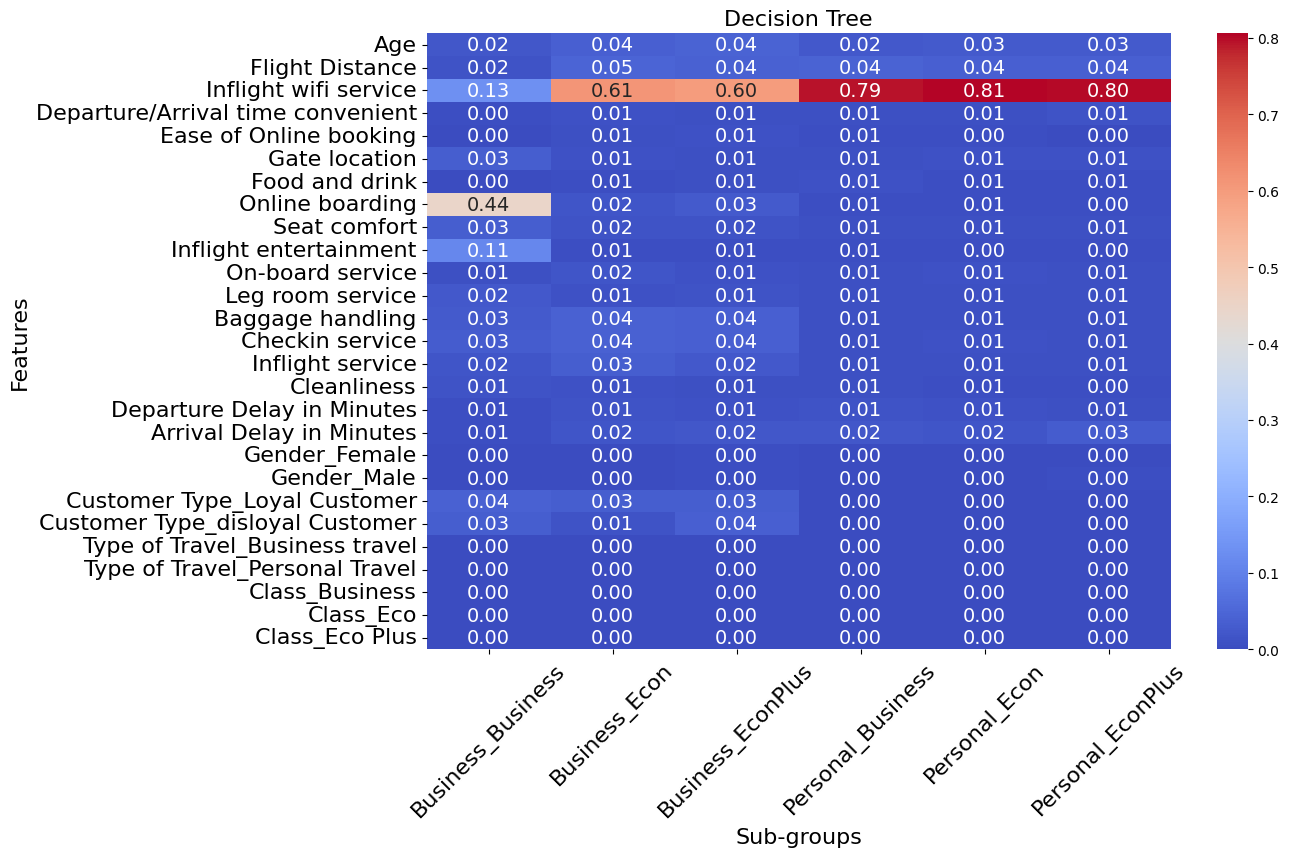

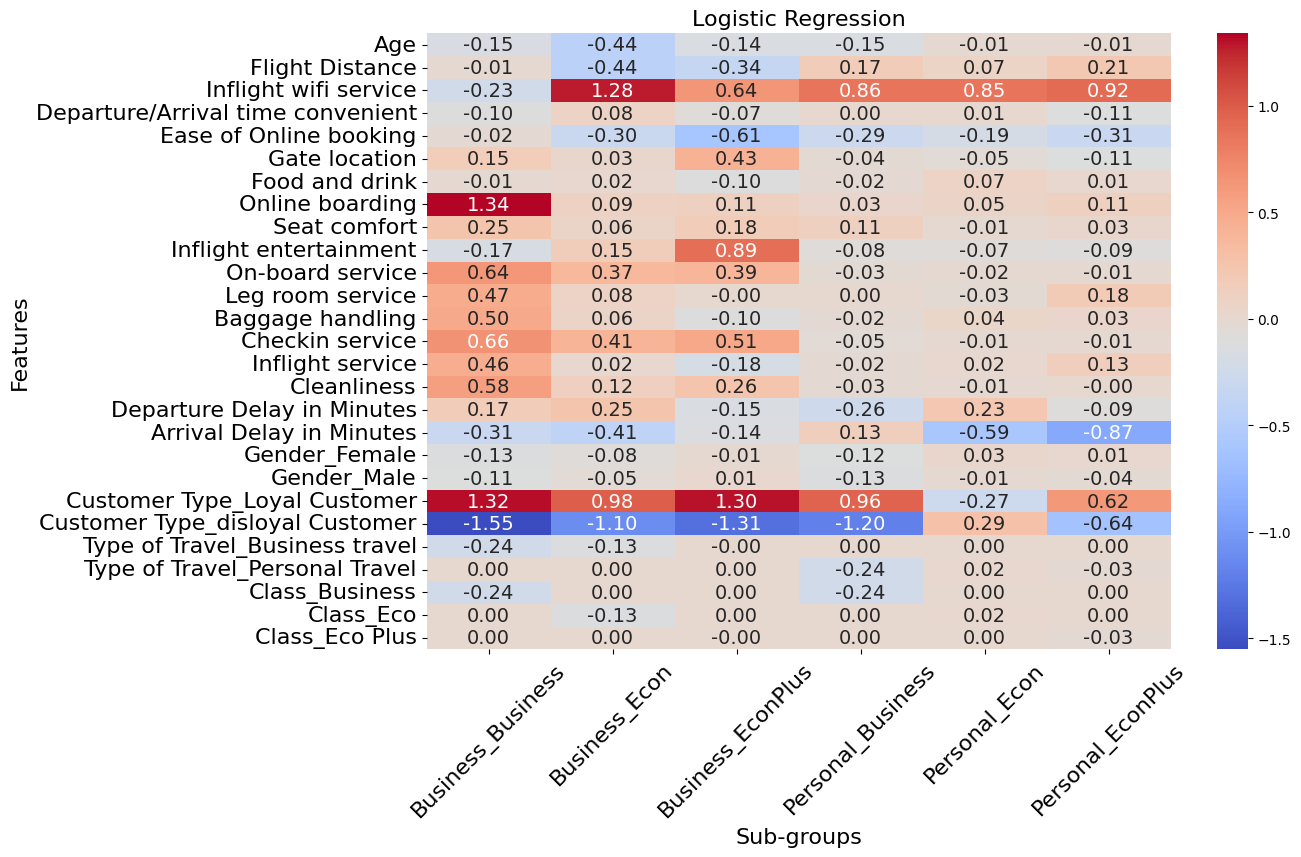

In [16]:
"""
visualize the importance of each feature for different subgroup
"""

def visualize_w(df,filename,x_label,title):
  plt.figure(figsize=(12,8))
  sns.heatmap(df, annot=True, annot_kws={'size': 14}, cmap='coolwarm', cbar=True, fmt=".2f")
  plt.xlabel(x_label,fontsize=16)
  plt.ylabel('Features',fontsize=16)
  plt.title(title,fontsize=16)
  plt.xticks(fontsize=16)
  plt.yticks(fontsize=16)
  plt.xticks(rotation=45)
  plt.savefig(filename,format='png',dpi=1000,bbox_inches='tight')
  plt.show()


feature_names = X_train.columns.values

# for DT models
df_dt = pd.DataFrame({
    'Business_Business': w_b_b_dt,
    'Business_Econ': w_b_e_dt,
    'Business_EconPlus': w_b_ep_dt,
    'Personal_Business': w_p_b_dt,
    'Personal_Econ': w_p_e_dt,
    'Personal_EconPlus': w_p_ep_dt
},index=feature_names)

visualize_w(df_dt,'DT_w_heatmap.png','Sub-groups','Decision Tree')

# for LR models
df_lr = pd.DataFrame({
    'Business_Business': w_b_b_lr,
    'Business_Econ': w_b_e_lr,
    'Business_EconPlus': w_b_ep_lr,
    'Personal_Business': w_p_b_lr,
    'Personal_Econ': w_p_e_lr,
    'Personal_EconPlus': w_p_ep_lr
},index=feature_names)
visualize_w(df_lr,'LR_w_heatmap.png','Sub-groups','Logistic Regression')

In [17]:
"""
report the predictive ability of each model (for each subgroup)
"""
# compile a table to report AUC, AUPRC, and F1
df_metrics_dt = pd.DataFrame({
    'Business_Business': result_b_b,
    'Business_Econ': result_b_e,
    'Business_EconPlus': result_b_ep,
    'Personal_Business': result_p_b,
    'Personal_Econ': result_p_e,
    'Personal_EconPlus': result_p_ep
},index=['AUC','AUPRC','F1'])
#df_metrics_dt = df_metrics_dt.reset_index().melt(id_vars='index', var_name='Category', value_name='Value')

df_metrics_lr = pd.DataFrame({
    'Business_Business': result_b_b_lr,
    'Business_Econ': result_b_e_lr,
    'Business_EconPlus': result_b_ep_lr,
    'Personal_Business': result_p_b_lr,
    'Personal_Econ': result_p_e_lr,
    'Personal_EconPlus': result_p_ep_lr
},index=['AUC','AUPRC','F1'])
#df_metrics_lr = df_metrics_lr.reset_index().melt(id_vars='index', var_name='Category', value_name='Value')

# visulization
# def visulize_metrics(df,title_str,filename):
#   sns.barplot(x='Category', y='Value', hue='index', data=df)
#   plt.xticks(rotation=90)
#   plt.xlabel('Sub-group')
#   plt.ylabel('Value')
#   plt.title(title_str,fontsize=14)
#   plt.tight_layout()
#   plt.xticks(rotation=45)
#   leg = plt.legend()
#   leg.set_title('Metrics')
#   plt.savefig(filename,format='png',dpi=800,bbox_inches='tight')
#   plt.show()

# visulize_metrics(df_metrics_dt,'Decision Tree','dt_metrics.png')
# visulize_metrics(df_metrics_lr,'Logistic Regression','lr_metrics.png')
display(df_metrics_dt)
display(df_metrics_lr)

,Business_Business,Business_Econ,Business_EconPlus,Personal_Business,Personal_Econ,Personal_EconPlus
AUC,0.993986,0.982166,0.980410,0.98359,0.974126,0.986557
AUPRC,0.996692,0.966441,0.970048,0.88061,0.848921,0.907950
F1,0.982087,0.905256,0.920882,0.74000,0.712397,0.785276


,Business_Business,Business_Econ,Business_EconPlus,Personal_Business,Personal_Econ,Personal_EconPlus
AUC,0.937546,0.889520,0.900583,0.751125,0.778120,0.808714
AUPRC,0.977876,0.840862,0.881257,0.566879,0.634395,0.612659
F1,0.900795,0.751476,0.793970,0.318966,0.365990,0.313253


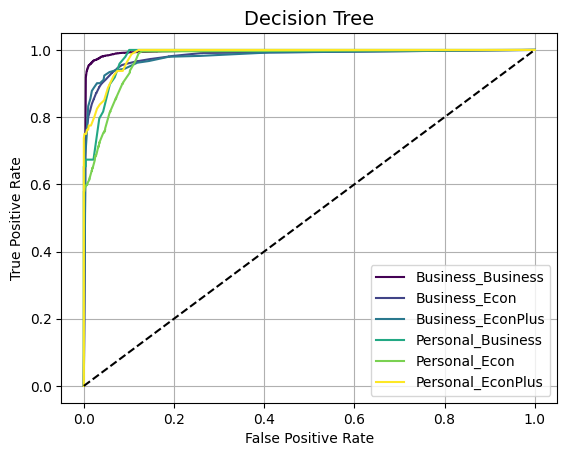

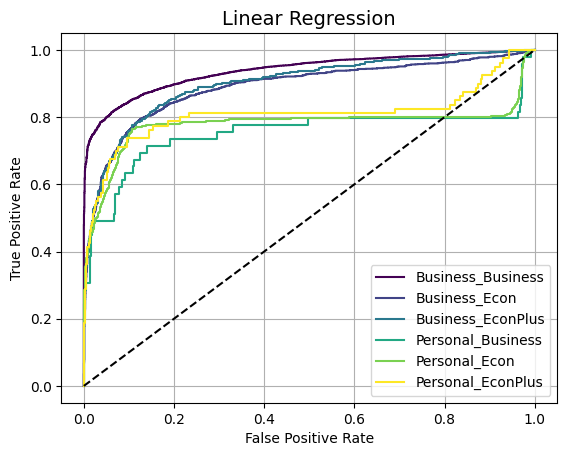

In [18]:
"""
draw roc curves for each model
"""
# prepare the roc data
def complie_roc_table(rocList,modelNames):
  result_df = pd.DataFrame({
      'fpr':[],
      'tpr':[],
      'model':[]
  })
  for i in range(len(modelNames)):
    model = [modelNames[i]] * len(rocList[i]['fpr'])
    new_df = pd.DataFrame({
      'fpr': rocList[i]['fpr'],
      'tpr': rocList[i]['tpr'],
      'model': model
    })
    result_df = pd.concat([result_df, new_df], ignore_index=True)
  return result_df

rocList_dt = [roc_b_b,roc_b_e,roc_b_ep,roc_p_b,roc_p_e,roc_p_ep]
rocList_lr = [roc_b_b_lr,roc_b_e_lr,roc_b_ep_lr,roc_p_b_lr,roc_p_e_lr,roc_p_ep_lr]
modelNames = ['Business_Business','Business_Econ','Business_EconPlus','Personal_Business','Personal_Econ','Personal_EconPlus']

dt_roc = complie_roc_table(rocList_dt,modelNames)
lr_roc = complie_roc_table(rocList_lr,modelNames)

# visualization
def visualize_roc(df,titleStr,filename):
  models = df['model'].unique()
  colors = plt.cm.viridis(np.linspace(0, 1, len(models)))
  for model, color in zip(models, colors):
    subset = df[df['model'] == model]
    plt.plot(subset['fpr'], subset['tpr'], label=model, color=color)
  plt.plot([0, 1], [0, 1], 'k--')
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title(titleStr,fontsize=14)
  plt.legend()
  plt.savefig(filename,format='png',dpi=800,bbox_inches='tight')
  plt.grid(True)
  plt.show()

visualize_roc(dt_roc,'Decision Tree','dt_rocs.png')
visualize_roc(lr_roc,'Linear Regression','lr_rocs.png')

In [14]:
print(1)

1
